# NSIDC EGI Interface

- https://github.com/creare-com/podpac/issues/237
- https://developer.earthdata.nasa.gov/sdps/programmatic-access-docs#curl
- https://nsidc.org/support/how/how-do-i-programmatically-request-data-services

In [6]:
import requests
import xml.etree.ElementTree
import socket

## Obtain Token

https://wiki.earthdata.nasa.gov/display/CMR/Creating+a+Token+Common

In [2]:
username = "username"
password = "password"
url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'

In [15]:
def get_ip():
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    try:
        s.connect(('8.8.8.8', 80))
        ip = s.getsockname()[0]
    except:
        ip = '127.0.0.1'
    finally:
        s.close()
    return ip

In [16]:
ip = get_ip()
request = """
<token>
    <username>{username}</username>
    <password>{password}</password>
    <client_id>podpac</client_id>
    <user_ip_address>{ip}</user_ip_address>
</token>
""".format(username=username, password=password,ip=ip)
headers = {"Content-Type": "application/xml"}
r = requests.post(url, data=request, headers=headers)

In [17]:
tree = xml.etree.ElementTree.fromstring(r.text)
token = [element.text for element in tree.findall('id')][0]

In [18]:
token

'A6D25979-2A42-7C5B-BEEC-0DF8B5D920AD'

## Get Data

In [45]:
base_url = "https://n5eil01u.ecs.nsidc.org/egi/request"
# base_url = "https://n5eil02u.ecs.nsidc.org/egi/request"
product = "SPL3SMA"
version = "003"
start_time = "2015-03-30"
end_time = "2015-06-12"
data_layers = "/Soil_Moisture_Retrieval_Data/soil_moisture"
bbox = "-70,42,-69,43"
# response_format = "HDF-EOS5"
response_format = "GeoTIFF"
token = token  # from above

In [66]:
url = "{base_url}?short_name={product}&version={version}".format(base_url=base_url, product=product, version=version,) + \
      "&time={start_time},{end_time}&Coverage={data_layers}".format(start_time=start_time, end_time=end_time, data_layers=data_layers, ) + \
      "&Bbox={bbox}&format={response_format}&token={token}".format(bbox=bbox, response_format=response_format, token=token)

r = requests.get(url)

In [67]:
with open('output.zip', 'wb') as f:
    f.write(r.content)

## Look at the Data

In [63]:
from podpac.data import Rasterio
import zipfile
%matplotlib inline

In [65]:
with zipfile.ZipFile("output.zip","r") as zip_ref:
    zip_ref.extractall()

In [51]:
node = Rasterio(source='78753123/SMAP_L3_SM_A_20150413_R13080_002_Soil_Moisture_Retrieval_Data_soil_moisture_1aec95e7.tif')

In [52]:
node.native_coordinates

Coordinates
	lat: UniformCoordinates1d(lat): Bounds[4903384.2652143845, 4996467.5], N[31], ctype['midpoint']
	lon: UniformCoordinates1d(lon): Bounds[-6756041.0, -6659955.0802213], N[32], ctype['midpoint']

In [54]:
node.native_coordinates.crs

'EPSG:4326'

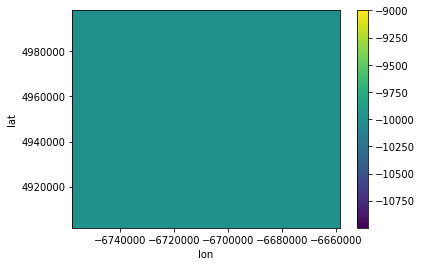

In [58]:
o = node.eval(node.native_coordinates)
o.plot()